# Dataset
By: Ethan Eckmann

Modifies the original dataset (converted to CSV) to drop some data fields that are irrelevant or redundant for our project.

Example: "Country" field can be dropped because all entries have identical values for this field

# Imports

In [ ]:
import pandas as pd

# Load dataset

In [ ]:
# Opens .CSV file
def extraction_step(file_name):
    try:
      with open(file_name, 'r') as f:
        df = pd.read_csv(file_name)
        return df

    except Exception as ee:
      print(f'An unexpected error occurred: {ee}')
      print(print(type(ee)))
      return None


# Transform dataset
Remove un-needed coloumns and correct data types.

In [ ]:
  # Corrects type error in dataset
def transform_df(df):
    # Total charges field was string when it should have been numeric, these lines correct this.
    df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
    df["Total Charges"] = df["Total Charges"].astype(float)
    # Needed because some "Total Charges" values appear as missing in the dataframe
    df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)
    return df

 # Drop irrelevant data columns and corrects type error in dataset
def transform_df_and_drop(df):
    # List of irrelevant data columns
    drop_col_list = ['City', 'Zip Code', 'Churn Reason', 'CustomerID', 'Count', 'Country', 'State', 'Lat Long', 'Latitude', 'Longitude', 'Phone Service', 'Internet Service', 'Contract', 'Churn Label']
    df = df.drop(drop_col_list, axis=1)

    # Total charges field was string when it should have been numeric, these lines correct this.
    df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors="coerce")
    df["Total Charges"] = df["Total Charges"].astype(float)
    # Needed because some "Total Charges" values appear as missing in the dataframe
    df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)
    return df


# Save updated .csv file

In [ ]:
# Saves dataframe to .CSV file
def save_dataset(df, string_name):
  df.to_csv(string_name + '.csv', header=True, index=False)

# df1 = extraction_step('Telco_customer_churn_A.csv')
df1 = extraction_step('Telco_customer_churn.csv')
df1 = transform_df(df1)
df2 = transform_df_and_drop(df1)
save_dataset(df1, 'Telco_customer_churn_A') # Dataset A. The original dataset converted to a .CSV file
save_dataset(df2, 'Telco_customer_churn_B') # Dataset B. Same as Dataset A, but with some columns dropped

<ipython-input-54-071802b0640c>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Total Charges"].fillna(df["Total Charges"].median(), inplace=True)
<ipython-input-54-071802b0640c>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, i



---


---




In [ ]:
# Missing values test
# Code from Suhas_Pote on Stack Overflow
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table

df = pd.read_csv("Telco_customer_churn_B.csv")
missing_zero_values_table(df)


# Identify columns with missing values
columns_with_missing = df.columns[df.isnull().any()].tolist()

# Print the column index for columns with missing values
print("Columns with missing values:")
for col in columns_with_missing:
    print(f"Column '{col}': Index {df.columns.get_loc(col)}")


Your selected dataframe has 19 columns and 7043 Rows.
There are 0 columns that have missing values.
Columns with missing values:


# Supervised Model
By: Rian Kahlon

The goal of this model is to accurately predict customer churn based off of other known data fields.

3 Different models were tested:



*   Logistic Regression
*   Random forest
*   XGBoost


XGBoost model was found to have the highest F1 score and is the ideal model for our project.



# Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Featurize data
Convert data fields of "String" type into numerical

In [ ]:
def featurize(df):
    X = df[[
        'Tenure Months',
        'Monthly Charges',
        'Total Charges',
        'CLTV'
    ]].copy()

    yes_no_cols = [
        'Senior Citizen', 'Partner', 'Dependents',
        'Multiple Lines', 'Online Security', 'Online Backup',
        'Device Protection', 'Tech Support',
        'Streaming TV', 'Streaming Movies',
        'Paperless Billing'
    ]
    for col in yes_no_cols:
        X[col] = df[col].apply(lambda x: 1 if x == 'Yes' else 0)

    X['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

    payment_map = {
        'Electronic check': 0,
        'Mailed check': 1,
        'Bank transfer (automatic)': 2,
        'Credit card (automatic)': 2
    }
    X['Payment Method'] = df['Payment Method'].map(payment_map)

    return X


In [ ]:
df = pd.read_csv("Telco_customer_churn_B.csv")
# apply featurize function and define
X = featurize(df)
y = df["Churn Value"]

# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression Model

In [ ]:
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

evaluation_results = {
"accuracy": accuracy,
"precision": precision,
"recall": recall,
"f1_score": f1,
"confusion_matrix": conf_matrix
}

evaluation_results

{'accuracy': 0.7927608232789212,
 'precision': 0.6741935483870968,
 'recall': 0.5225,
 'f1_score': 0.5887323943661972,
 'confusion_matrix': array([[908, 101],
        [191, 209]])}

Random Forest Model

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

rf_results = {
    "accuracy": accuracy_rf,
    "precision": precision_rf,
    "recall": recall_rf,
    "f1_score": f1_rf,
    "confusion_matrix": conf_matrix_rf
}

rf_results

{'accuracy': 0.794889992902768,
 'precision': 0.6920415224913494,
 'recall': 0.5,
 'f1_score': 0.5805515239477503,
 'confusion_matrix': array([[920,  89],
        [200, 200]])}

XGBoost Model

In [ ]:
xgb_clf = XGBClassifier(
    max_depth=6,
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_xgb)
precision = precision_score(y_test, y_pred_xgb)
recall = recall_score(y_test, y_pred_xgb)
f1 = f1_score(y_test, y_pred_xgb)
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

xgb_results = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1_score": f1,
    "confusion_matrix": conf_matrix
}

xgb_results

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


{'accuracy': 0.7991483321504613,
 'precision': 0.6857142857142857,
 'recall': 0.54,
 'f1_score': 0.6041958041958042,
 'confusion_matrix': array([[910,  99],
        [184, 216]])}

# Add "Probability" as a field into the dataset
By: Ethan Eckmann

In [ ]:
# Probability field
# Create a predicted value for each entry using XGB model
import numpy

# apply featurize function and define
df1 = pd.read_csv("Telco_customer_churn_A.csv")
df2 = pd.read_csv("Telco_customer_churn_B.csv")

# Create new column in dataframe. Set all values to None by default
df1["Probability"] = 0
df2["Probability"] = 0

X = featurize(df2)
y = df2['Churn Value']


# XGB
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_clf = XGBClassifier(
    max_depth=6,
    n_estimators=200,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

# For each entry, take into account these fields
for index, row in X.iterrows():
  Tenure_Months = row['Tenure Months']
  Monthly_Charges = row['Monthly Charges']
  Total_Charges = row['Total Charges']
  CLTV = row['CLTV']
  Senior_Citizen = row['Senior Citizen']
  Partner = row['Partner']
  Dependents = row['Dependents']
  Multiple_Lines = row['Multiple Lines']
  Online_Security = row['Online Security']
  Online_Backup = row['Online Backup']
  Device_Protection = row['Device Protection']
  Tech_Support = row['Tech Support']
  Streaming_TV = row['Streaming TV']
  Streaming_Movies = row['Streaming Movies']
  Paperless_Billing = row['Paperless Billing']
  Gender = row['Gender']
  Payment_Method = row['Payment Method']

  input_data = numpy.array([[Tenure_Months,
                             Monthly_Charges,
                             Total_Charges,
                             CLTV,
                             Senior_Citizen,
                             Partner,
                             Dependents,
                             Multiple_Lines,
                             Online_Security,
                             Online_Backup,
                             Device_Protection,
                             Tech_Support,
                             Streaming_TV,
                             Streaming_Movies,
                             Paperless_Billing,
                             Gender,
                             Payment_Method]])

  y_pred_xgb = xgb_clf.predict(input_data)
  score = xgb_clf.predict_proba(input_data)

  if df1.loc[index, "Churn Value"] == 1: # if entry is not churned set value to None
    # Add the score to the entry's Probability field
    df1.loc[index, "Probability"] = score[0][1]
    df2.loc[index, "Probability"] = score[0][1]
  else:
    df1.loc[index, "Probability"] = None
    df2.loc[index, "Probability"] = None

save_dataset(df1, "churn_predict_A")
save_dataset(df2, "churn_predict_B")

# Confirm that all dataframes have the same number of entries and therefore the same indexies
num_rows1 = len(df1)
num_rows2 = len(df2)
num_rows3 = len(X)
print(num_rows1)
print(num_rows2)
print(num_rows3)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:32:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
<ipython-input-65-b430ac4de00f>:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5907096266746521' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df1.loc[index, "Probability"] = score[0][1]
<ipython-input-65-b430ac4de00f>:76: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5907096266746521' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df2.loc[index, "Probability"] = score[0][1]


7043
7043
7043


## CLTV vs Probability
By: Ethan Eckmann

Conclusion:

CLTV (Customer Life Time Value) is not correlated with Probability

Very low p-value, so correlation coefficient is likely correct

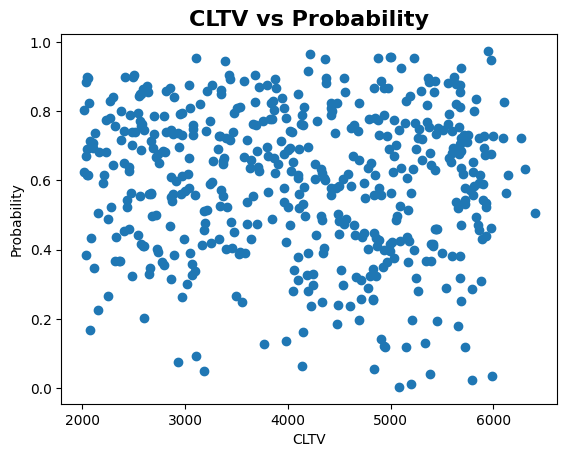

The Pearsonr Pearson Correlation Coefficient for CLTV vs Probability = -0.10686437490942835

p-value = 3.654423200583537e-06



In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

df = pd.read_csv('churn_predict_B.csv')
select_entries = df[:500]

# Condition for removal (e.g., remove rows where 'Probability' is None)
condition = df['Probability'].notnull()

# Apply the condition to filter rows
df_filtered = df[condition]

x_axis = select_entries['CLTV']
y_axis = select_entries['Probability']

# Pearsonr Pearson Correlation Coefficient
cc, p = pearsonr(df_filtered['CLTV'], df_filtered['Probability'])

plt.scatter(x_axis,y_axis, marker='o')
plt.xlabel('CLTV')
plt.ylabel('Probability')
plt.title('CLTV vs Probability', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()
print(f'The Pearsonr Pearson Correlation Coefficient for CLTV vs Probability = {cc}\n')
print(f'p-value = {p}\n')

## Probability (our ML model's churn prediction value) vs Churn Score (the original risk prediction in the dataset)
By: Ethan Eckmann

Conclusion:

Probability (our ML model's churn prediction value) is not correlated with Chrun score (the original risk prediction in the dataset).

Our approach to risk prediction is likely different compared to Telco's approach.

High p-value, so correlation coefficient might be statistcally insignificant

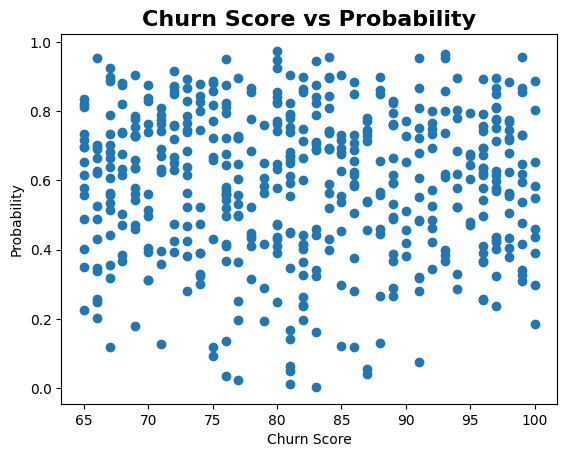

The Pearsonr Pearson Correlation Coefficient for Churn Score vs Probability = -0.020755943701178656

p-value = 0.3698171902387501



In [ ]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

df = pd.read_csv('churn_predict_B.csv')
select_entries = df[:500]

# Condition for removal (e.g., remove rows where 'Probability' is None)
condition = df['Probability'].notnull()

# Apply the condition to filter rows
df_filtered = df[condition]

x_axis = select_entries['Churn Score']
y_axis = select_entries['Probability']

# Pearsonr Pearson Correlation Coefficient
cc, p = pearsonr(df_filtered['Churn Score'], df_filtered['Probability'])

plt.scatter(x_axis,y_axis, marker='o')
plt.xlabel('Churn Score')
plt.ylabel('Probability')
plt.title('Churn Score vs Probability', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.show()
print(f'The Pearsonr Pearson Correlation Coefficient for Churn Score vs Probability = {cc}\n')
print(f'p-value = {p}\n')

## Churn reason pie chart
By: Ethan Eckmann

Conclusion:

The top three reasons are:

1.   'Attitude of support person': 10.3%
2.   'Competitor offered higher download speeds': 10.1%
3.    'Competitor offered more data': 8.7%







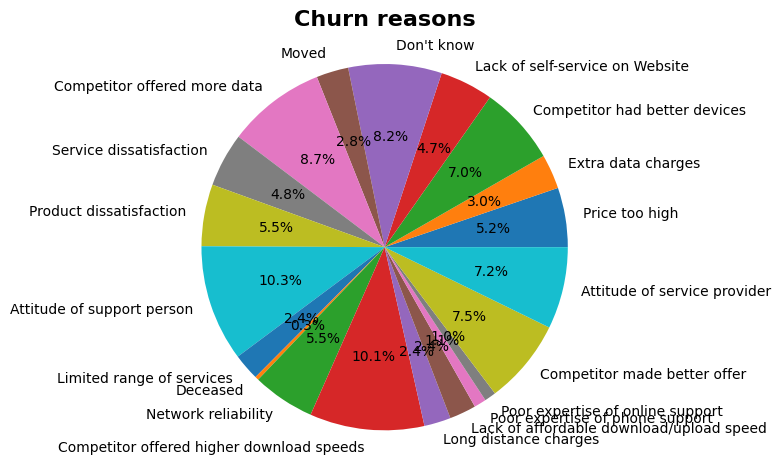

{'Attitude of support person': 10.272873194221509, 'Competitor offered higher download speeds': 10.112359550561797, 'Competitor offered more data': 8.667736757624397, "Don't know": 8.239700374531834, 'Competitor made better offer': 7.490636704119851, 'Attitude of service provider': 7.223113964686998, 'Competitor had better devices': 6.955591225254147, 'Network reliability': 5.510968432316747, 'Product dissatisfaction': 5.457463884430177, 'Price too high': 5.2434456928838955, 'Service dissatisfaction': 4.761904761904762, 'Lack of self-service on Website': 4.708400214018192, 'Extra data charges': 3.0497592295345104, 'Moved': 2.8357410379882286, 'Limited range of services': 2.354200107009096, 'Long distance charges': 2.354200107009096, 'Lack of affordable download/upload speed': 2.354200107009096, 'Poor expertise of phone support': 1.070090957731407, 'Poor expertise of online support': 1.0165864098448367, 'Deceased': 0.32102728731942215}


In [ ]:
from math import nan
df = pd.read_csv("Telco_customer_churn_A.csv")

df = df.dropna(subset=['Churn Reason']) # Drop empty values

ChurnReason_list = []
ChurnReason_freq_list = []
for index, row in df.iterrows():
  cr = row['Churn Reason']
  ChurnReason_list.append(cr)

unique_CR_list = list(set(ChurnReason_list)) # make list of unique churn reasons

for i in unique_CR_list:
  ChurnReason_freq_list.append(ChurnReason_list.count(i)) # the numerical frequency of churn reasons

# Create pie chart
plt.pie(ChurnReason_freq_list, labels=unique_CR_list, autopct='%1.1f%%')
plt.title('Churn reasons', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.axis('equal')
plt.show()

# Create dictionary, and then and print sorted descending for better reading
ChurnReason_precent_list = []
for i in range(len(ChurnReason_freq_list)):
  ChurnReason_precent_list.append(ChurnReason_freq_list[i]/sum(ChurnReason_freq_list)*100)
keys = unique_CR_list
values = ChurnReason_precent_list
my_dict = dict(zip(keys, values))
sorted_dict_desc = dict(sorted(my_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict_desc)




# Further analysis
By: Rian Kahlon


Shows what features the model relied on most

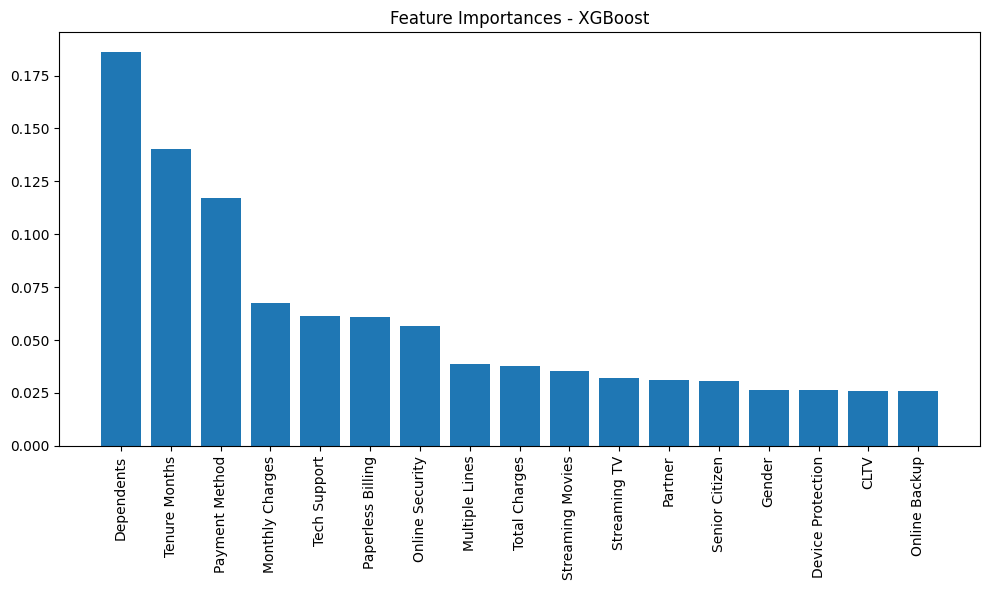

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

importances = xgb_clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances - XGBoost")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()


Further explains model behavior by showing reason behind each perdiction

In [ ]:
from IPython.display import display

correct_preds = X_test.copy()
correct_preds["Actual"] = y_test
correct_preds["Predicted"] = xgb_clf.predict(X_test)
correct_preds["Probability"] = xgb_clf.predict_proba(X_test)[:, 1]
correct_preds = correct_preds[correct_preds["Actual"] == correct_preds["Predicted"]]
correct_preds = correct_preds.sort_values(by="Probability", ascending=False).head()

incorrect_preds = X_test.copy()
incorrect_preds["Actual"] = y_test
incorrect_preds["Predicted"] = xgb_clf.predict(X_test)
incorrect_preds["Probability"] = xgb_clf.predict_proba(X_test)[:, 1]
incorrect_preds = incorrect_preds[incorrect_preds["Actual"] != incorrect_preds["Predicted"]]
incorrect_preds = incorrect_preds.sort_values(by="Probability", ascending=False).head()

print("Correct Predictions:")
display(correct_preds[[
    'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV',
    'Online Security', 'Tech Support', 'Partner', 'Gender',
    'Payment Method', 'Actual', 'Predicted', 'Probability'
]])

print()

print("Incorrect Predictions:")
display(incorrect_preds[[
    'Tenure Months', 'Monthly Charges', 'Total Charges', 'CLTV',
    'Online Security', 'Tech Support', 'Partner', 'Gender',
    'Payment Method', 'Actual', 'Predicted', 'Probability'
]])

Correct Predictions:


,Tenure Months,Monthly Charges,Total Charges,CLTV,Online Security,Tech Support,Partner,Gender,Payment Method,Actual,Predicted,Probability
1195,1,80.55,80.55,4273,0,0,1,1,0,1,1,0.961989
435,1,79.10,79.10,5001,0,0,0,1,0,1,1,0.956052
1087,1,85.45,85.45,4931,0,0,0,0,0,1,1,0.949291
245,2,96.00,174.80,3391,0,0,0,0,0,1,1,0.943922
1183,11,99.55,1131.20,3172,0,0,1,0,0,1,1,0.940479



Incorrect Predictions:


,Tenure Months,Monthly Charges,Total Charges,CLTV,Online Security,Tech Support,Partner,Gender,Payment Method,Actual,Predicted,Probability
5657,1,89.25,89.25,5579,0,0,0,1,0,0,1,0.953885
3732,2,91.45,171.45,4889,0,0,1,1,0,0,1,0.927846
2676,1,80.55,80.55,3154,0,0,0,1,0,0,1,0.924087
2215,1,75.10,75.10,4120,0,0,0,1,0,0,1,0.900241
3012,6,80.80,457.10,5611,0,0,1,1,0,0,1,0.825749


# Interpretability
By: Rian Kahlon

In [ ]:
try:
    import lime
except:
    !pip install lime
    import lime
from lime import lime_tabular

# apply featurize function
df = pd.read_csv("Telco_customer_churn_B.csv")
X = featurize(df)

train_features = X[['Tenure Months',
                             'Monthly Charges',
                             'Total Charges',
                             'CLTV',
                             'Senior Citizen',
                             'Partner',
                             'Dependents',
                             'Multiple Lines',
                             'Online Security',
                             'Online Backup',
                             'Device Protection',
                             'Tech Support',
                             'Streaming TV',
                             'Streaming Movies',
                             'Paperless Billing',
                             'Gender',
                             'Payment Method']]


explainer = lime_tabular.LimeTabularExplainer(
    training_data=train_features.to_numpy(),
    feature_names=train_features.columns,
    class_names=[0, 1],
    mode='classification'
)





row = X.iloc[0]
Tenure_Months = row['Tenure Months']
Monthly_Charges = row['Monthly Charges']
Total_Charges = row['Total Charges']
CLTV = row['CLTV']
Senior_Citizen = row['Senior Citizen']
Partner = row['Partner']
Dependents = row['Dependents']
Multiple_Lines = row['Multiple Lines']
Online_Security = row['Online Security']
Online_Backup = row['Online Backup']
Device_Protection = row['Device Protection']
Tech_Support = row['Tech Support']
Streaming_TV = row['Streaming TV']
Streaming_Movies = row['Streaming Movies']
Paperless_Billing = row['Paperless Billing']
Gender = row['Gender']
Payment_Method = row['Payment Method']

input_data = numpy.array([[Tenure_Months,
                             Monthly_Charges,
                             Total_Charges,
                             CLTV,
                             Senior_Citizen,
                             Partner,
                             Dependents,
                             Multiple_Lines,
                             Online_Security,
                             Online_Backup,
                             Device_Protection,
                             Tech_Support,
                             Streaming_TV,
                             Streaming_Movies,
                             Paperless_Billing,
                             Gender,
                             Payment_Method]])

exp = explainer.explain_instance(
    data_row=input_data[0],
    predict_fn=xgb_clf.predict_proba
)

exp.show_in_notebook(show_table=True)

Used SHAP to show explain how each feature impacts the ML model.

Right indicates positive push for churn

Left indicates negative push for churn

red indicats high value

blue indicates low value

 99%|===================| 6977/7043 [01:20<00:00]       

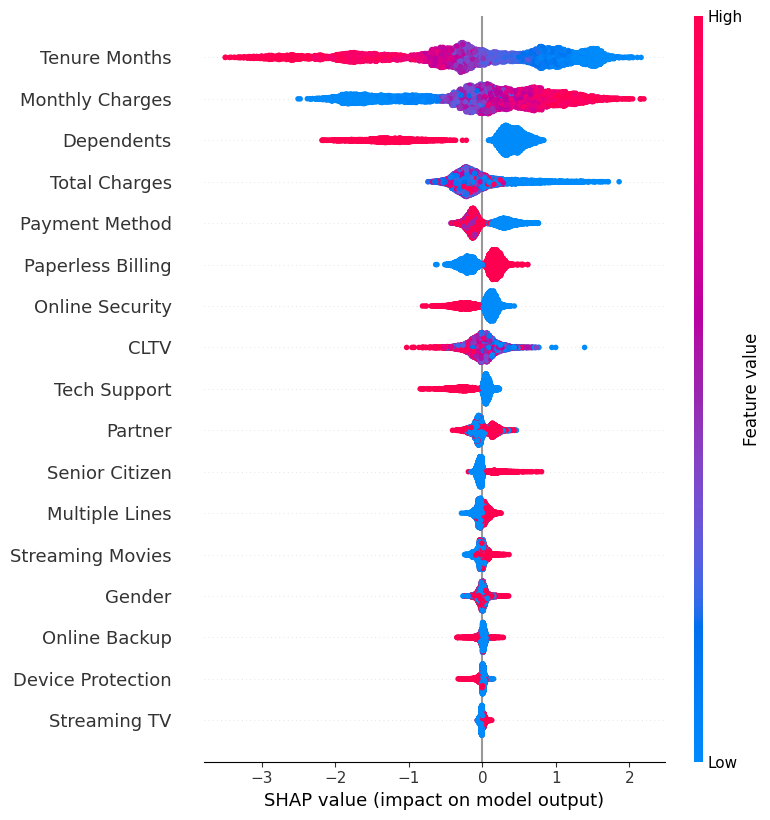

In [ ]:
import shap

explainer = shap.Explainer(xgb_clf, X)

shap_values = explainer(X)
shap.summary_plot(shap_values, X)


In [ ]:
df = pd.read_csv("Telco_customer_churn_B.csv")
churn_by_payment = df.groupby("Payment Method")["Churn Value"].mean().sort_values(ascending=False)

print(churn_by_payment)

Payment Method
Electronic check             0.452854
Mailed check                 0.191067
Bank transfer (automatic)    0.167098
Credit card (automatic)      0.152431
Name: Churn Value, dtype: float64


In [ ]:
explainer = shap.Explainer(xgb_clf, X)
shap_values = explainer(X)

payment_col_index = list(X.columns).index("Payment Method")

for value, label in [(0, "Electronic check"), (1, "Mailed check"), (2, "Auto-pay")]:
    mask = X["Payment Method"] == value
    shap_impact = shap_values.values[mask, payment_col_index]
    avg_impact = np.mean(shap_impact)
    print(f"{label}: Avg SHAP impact on churn = {avg_impact:.4f}")


 99%|===================| 6994/7043 [01:46<00:00]       

Electronic check: Avg SHAP impact on churn = 0.3262
Mailed check: Avg SHAP impact on churn = -0.1733
Auto-pay: Avg SHAP impact on churn = -0.1243
